In [263]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [264]:
import warnings
warnings.filterwarnings('ignore')

In [265]:
news = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Fake News Classifier/FakeNewsNet.csv')
news.head(3)

,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1


In [266]:
news[news['real'] == 0].head()['title']

5     Gwen Stefani Got Dumped by Blake Shelton Over ...
6     Broward County Sheriff Fired For Lying About P...
7     Amber Rose Shuts Down French Montana Dating Ru...
11    Mel Gibson: Hollywood Pedophiles Have Nowhere ...
15    5 Reasons Why Tarek El Moussa Will Overcome Hi...
Name: title, dtype: object

In [267]:
news.shape

(23196, 5)

In [268]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23196 entries, 0 to 23195
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          23196 non-null  object
 1   news_url       22866 non-null  object
 2   source_domain  22866 non-null  object
 3   tweet_num      23196 non-null  int64 
 4   real           23196 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 906.2+ KB


In [269]:
def nulls_info(df):
  c = df.isnull().sum().rename('count')
  d = df.isnull().mean().rename('distribution')*100
  nulls = pd.concat([c,d], axis =1)
  nulls.index.name = 'column_name'
  nulls.reset_index(inplace = True)
  return nulls

In [270]:
nulls_info(news)

,column_name,count,distribution
0,title,0,0.000000
1,news_url,330,1.422659
2,source_domain,330,1.422659
3,tweet_num,0,0.000000
4,real,0,0.000000


In [271]:
### lets remove the records contating the null values

In [272]:
news = news[~news['news_url'].isnull()]
news = news[~news['source_domain'].isnull()]

In [273]:
nulls_info(news)

,column_name,count,distribution
0,title,0,0.0
1,news_url,0,0.0
2,source_domain,0,0.0
3,tweet_num,0,0.0
4,real,0,0.0


In [274]:
news['real'].value_counts(normalize = True)

1    0.759687
0    0.240313
Name: real, dtype: float64

Arriving at new columns

In [275]:
news['word_count'] = news['title'].apply(lambda x : len(x.split(' ')))

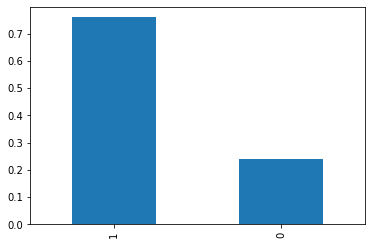

In [276]:
news['real'].value_counts(normalize = True).plot.bar()
plt.show()

In [277]:
### The distribution looks good in the sample data, 25% could be the right wieghtage for a news being fake,

In [278]:
rectify_sampling_imbalance = True

In [279]:
if rectify_sampling_imbalance == True:
  features = news.drop('real', 1)
  target = news['real']
  from imblearn.over_sampling import RandomOverSampler
  ros = RandomOverSampler(random_state=100)
  featues_ros, target_ros = ros.fit_resample(features,target)
  news_oversampled = pd.concat([featues_ros,target_ros], axis = 1)
  news = news_oversampled

In [280]:
X = news['title']
y = news['real']

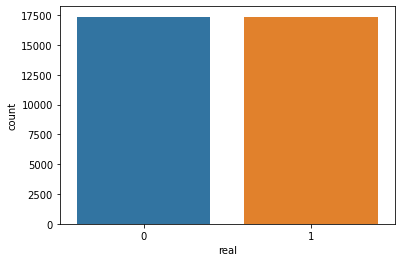

In [281]:
sns.countplot(y)
plt.show()

In [282]:
from sklearn.model_selection import train_test_split

In [283]:
X_train,X_test, y_train,y_test = train_test_split(X,y, train_size = 0.70, random_state = 100, stratify = y)

Tokenizer

Transforms each text in texts to a sequence of integers. Each item in texts can also be a list, in which case we assume each item of that list to be a token. Only top num_words-1 most frequent words will be taken into account. Only words known by the tokenizer will be taken into account.

In [284]:
from tensorflow import keras as kr

In [285]:
tokn = kr.preprocessing.text.Tokenizer(num_words=None,
                                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                      lower=True,
                                      split=' ',
                                      char_level=False,
                                      oov_token=None)

In [286]:
tokn.fit_on_texts(X_train)

text to sequence



In [287]:
X_train_tokn = tokn.texts_to_sequences(X_train)

In [288]:
X_test_tokn = tokn.texts_to_sequences(X_test)

In [289]:
max_word_count = int(news['word_count'].quantile(0.80))

In [290]:
X_train_padded = kr.preprocessing.sequence.pad_sequences(X_train_tokn, maxlen = max_word_count , padding = 'post')

In [291]:
X_test_padded = kr.preprocessing.sequence.pad_sequences(X_test_tokn, maxlen = max_word_count , padding = 'post')

In [292]:
X_train_padded

array([[ 189,  111,  244, ...,    0,    0,    0],
       [4289,    7,   59, ..., 3911,    5, 1266],
       [1116,   28,  277, ...,    0,    0,    0],
       ...,
       [2347, 2685, 5718, ...,    0,    0,    0],
       [ 121,   14,    0, ...,    0,    0,    0],
       [ 242,    9,   86, ...,    0,    0,    0]], dtype=int32)

In [293]:
from sklearn.preprocessing import StandardScaler

In [294]:
sc = StandardScaler()

In [295]:
X_train_padded_sc = sc.fit_transform(X_train_padded)

In [296]:
X_test_padded_sc = sc.transform(X_test_padded)

In [297]:
from sklearn.tree import DecisionTreeClassifier

In [298]:
dt = DecisionTreeClassifier(min_samples_leaf = 30)

In [299]:
dt.fit(X_train_padded_sc,y_train)

DecisionTreeClassifier(min_samples_leaf=30)

Lets check the matrix for the Decision Tree

In [300]:
def evaluate_matrics (estimator):
  from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,roc_auc_score,confusion_matrix
  
  train_pred = estimator.predict(X_train_padded_sc)
  test_pred = estimator.predict(X_test_padded_sc)

  accuracy_train = round(accuracy_score(y_train,train_pred),4)
  accuracy_test = round(accuracy_score(y_test,test_pred),4)
  accuracy_delta = round(accuracy_train-accuracy_test,4)

  precision_train = round(precision_score(y_train,train_pred),4)
  precision_test = round(precision_score(y_test,test_pred),4)
  precision_delta = round(precision_train-precision_test,4)

  recall_train = round(recall_score(y_train,train_pred),4)
  recall_test = round(recall_score(y_test,test_pred),4)
  recall_delta = round(recall_train-recall_test,4)
  
  f1_train = round(f1_score(y_train,train_pred),4)
  f1_test = round(f1_score(y_test,test_pred),4)
  f1_delta = round(f1_train-f1_test,4)

  roc_auc_train = round(roc_auc_score(y_train,train_pred),4)
  roc_auc_test = round(roc_auc_score(y_test,test_pred),4)
  roc_acu_delta = round(roc_auc_train-roc_auc_test,4)

  confusion_train = pd.DataFrame(confusion_matrix(y_train,train_pred))
  specificity_train = round(confusion_train.iloc[0,0]/(confusion_train.iloc[0,0]+confusion_train.iloc[0,1]),4)
  confusion_test = pd.DataFrame(confusion_matrix(y_test,test_pred))
  specificity_test = round(confusion_test.iloc[0,0]/(confusion_test.iloc[0,0]+confusion_test.iloc[0,1]),4)
  specificity_delat = round(specificity_train - specificity_test,4)


  metrics = ['accuracy','specificity','precision','recall','f1_score','roc_auc']
  train_metric = [accuracy_train,specificity_train,precision_train,recall_train,f1_train,roc_auc_train]
  test_metric = [accuracy_test,specificity_test,precision_test,recall_test,f1_test,roc_auc_test]
  delta_metric = [accuracy_delta,specificity_delat,precision_delta,recall_delta,f1_delta,roc_acu_delta]


  metrics_df = pd.DataFrame({'metric':metrics,'train':train_metric,'test':test_metric,'delta':delta_metric})
  return metrics_df

In [301]:
evaluate_matrics(dt)

,metric,train,test,delta
0,accuracy,0.7894,0.6734,0.1160
1,specificity,0.8026,0.7193,0.0833
2,precision,0.7973,0.6909,0.1064
3,recall,0.7762,0.6275,0.1487
4,f1_score,0.7866,0.6577,0.1289
5,roc_auc,0.7894,0.6734,0.1160


This model is highly overfitting

Need to increase the model complexity

In [302]:
from sklearn.ensemble import RandomForestClassifier

In [303]:
rfc = RandomForestClassifier(n_estimators = 200, min_samples_leaf = 30, criterion ='gini')

In [304]:
rfc.fit(X_train_padded_sc,y_train)

RandomForestClassifier(min_samples_leaf=30, n_estimators=200)

In [305]:
evaluate_matrics(rfc)

,metric,train,test,delta
0,accuracy,0.8364,0.7151,0.1213
1,specificity,0.8837,0.7970,0.0867
2,precision,0.8716,0.7572,0.1144
3,recall,0.7891,0.6333,0.1558
4,f1_score,0.8283,0.6897,0.1386
5,roc_auc,0.8364,0.7151,0.1213


In [306]:
from sklearn.model_selection import GridSearchCV

In [307]:
estimator = RandomForestClassifier()

In [308]:
params = {'n_estimators' : [100,200,300], 
          'min_samples_leaf' : [50,30,20], 
          'criterion' : ['gini']}

In [309]:
gridsearch = GridSearchCV(estimator, 
             param_grid = params, 
             scoring='accuracy', 
             n_jobs= -1, refit=True,
             verbose=1)

In [310]:
gridsearch.fit(X_train_padded_sc,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'],
                         'min_samples_leaf': [50, 30, 20],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=1)

In [311]:
best_estimator_rf = gridsearch.best_estimator_

In [312]:
evaluate_matrics(best_estimator_rf)

,metric,train,test,delta
0,accuracy,0.8663,0.7383,0.1280
1,specificity,0.9036,0.8172,0.0864
2,precision,0.8958,0.7829,0.1129
3,recall,0.8289,0.6594,0.1695
4,f1_score,0.8611,0.7158,0.1453
5,roc_auc,0.8663,0.7383,0.1280


Lets Try an XG Boost Model

In [313]:
from xgboost import XGBClassifier

In [314]:
xgb = XGBClassifier()

In [315]:
xgb.fit(X_train_padded_sc,y_train)

XGBClassifier()

In [316]:
evaluate_matrics(xgb)

,metric,train,test,delta
0,accuracy,0.7202,0.6375,0.0827
1,specificity,0.8006,0.7577,0.0429
2,precision,0.7624,0.6810,0.0814
3,recall,0.6398,0.5174,0.1224
4,f1_score,0.6958,0.5880,0.1078
5,roc_auc,0.7202,0.6375,0.0827


In [320]:
final_model = best_estimator_rf

**Exporting the files for Deployement**

1. maximum word count
2. tokenize object
3. scaler object
4. classifier

In [321]:
import pickle

In [323]:
pickle.dump(max_word_count,open('word_counter.pkl','wb'))
pickle.dump(tokn,open('tokenizer.pkl','wb'))
pickle.dump(sc,open('scaler.pkl','wb'))
pickle.dump(final_model,open('classifier.pkl','wb'))

**End of the document**